In [1]:
!pip install lyft_dataset_sdk

In [67]:
import os
import gc
import numpy as np
import pandas as pd

import json
import math
import sys
import time
from datetime import datetime
from typing import Tuple, List
from IPython.display import HTML

import cv2
import matplotlib.pyplot as plt
import sklearn.metrics
from PIL import Image

from matplotlib.axes import Axes
from matplotlib import animation, rc
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import plot, init_notebook_mode
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

import seaborn as sns
from pyquaternion import Quaternion
from tqdm import tqdm

from lyft_dataset_sdk.utils.map_mask import MapMask
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.geometry_utils import view_points, box_in_image, BoxVisibility
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from pathlib import Path

import struct
from abc import ABC, abstractmethod
from functools import reduce
from typing import Tuple, List, Dict
import copy

In [7]:
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
object_columns = ['sample_id', 'object_id', 'center_x', 'center_y', 'center_z',
                  'width', 'length', 'height', 'yaw', 'class_name']
objects = []
for sample_id, ps in tqdm(train.values[:]):
    object_params = ps.split()
    n_objects = len(object_params)
    for i in range(n_objects // 8):
        x, y, z, w, l, h, yaw, c = tuple(object_params[i * 8: (i + 1) * 8])
        objects.append([sample_id, i, x, y, z, w, l, h, yaw, c])
train_objects = pd.DataFrame(
    objects,
    columns = object_columns
)

100%|██████████| 22680/22680 [00:02<00:00, 8731.72it/s]


In [9]:
numerical_cols = ['object_id', 'center_x', 'center_y', 'center_z', 'width', 'length', 'height', 'yaw']
train_objects[numerical_cols] = np.float32(train_objects[numerical_cols].values)

In [10]:
train_objects.head()

sample_id  object_id     center_x  \
0  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        0.0  2680.282959   
1  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        1.0  2691.997559   
2  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        2.0  2713.607422   
3  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        3.0  2679.986816   
4  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...        4.0  2659.352051   

     center_y   center_z  width  length  height       yaw class_name  
0  698.196899 -18.047768  2.064   5.488   2.053  2.604164        car  
1  660.801636 -18.674259  1.818   4.570   1.608 -0.335176        car  
2  694.403503 -18.589972  1.779   4.992   1.620  2.579456        car  
3  706.910156 -18.349594  1.798   3.903   1.722  2.586166        car  
4  719.417480 -18.442999  1.936   4.427   1.921  2.601799        car

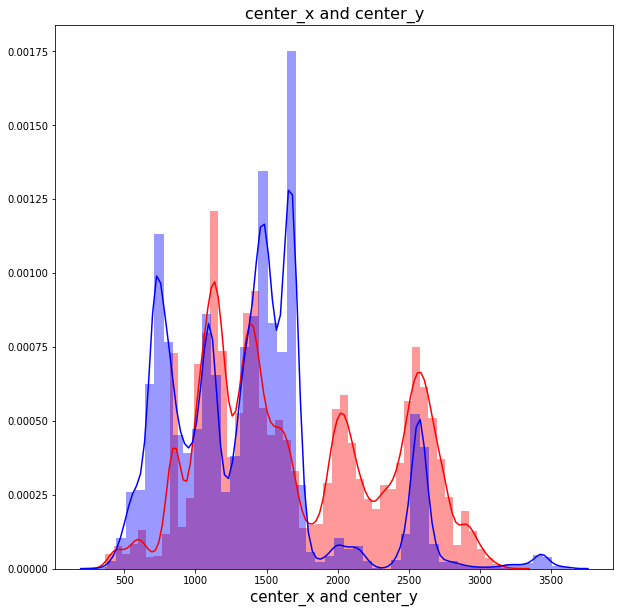

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_x'], color='red', ax=ax).set_title('center_x and center_y', fontsize=16)
sns.distplot(train_objects['center_y'], color='blue', ax=ax).set_title('center_x and center_y', fontsize=16)
plt.xlabel('center_x and center_y', fontsize=15)
plt.show()

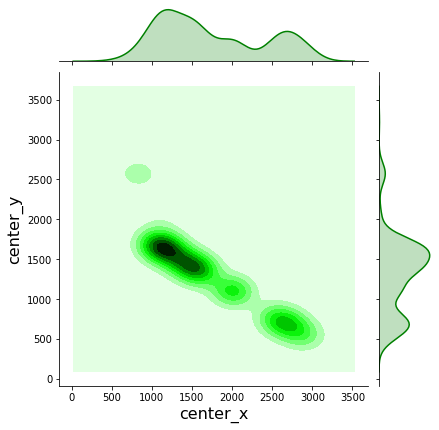

In [92]:
new_train_objects = train_objects.query('class_name == "car"')
plot = sns.jointplot(x=new_train_objects['center_x'][:1000], y=new_train_objects['center_y'][:1000], kind='kde', color='green')
plot.set_axis_labels('center_x', 'center_y', fontsize=16)
plt.show()

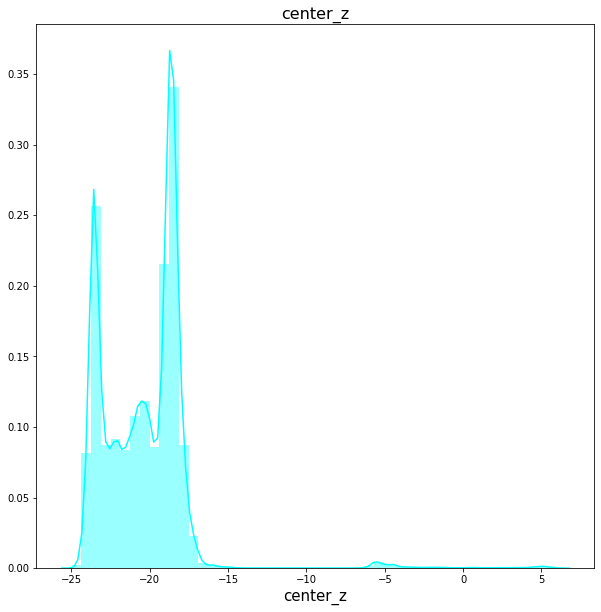

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['center_z'], color='cyan', ax=ax).set_title('center_z', fontsize=16)
plt.xlabel('center_z', fontsize=15)
plt.show()

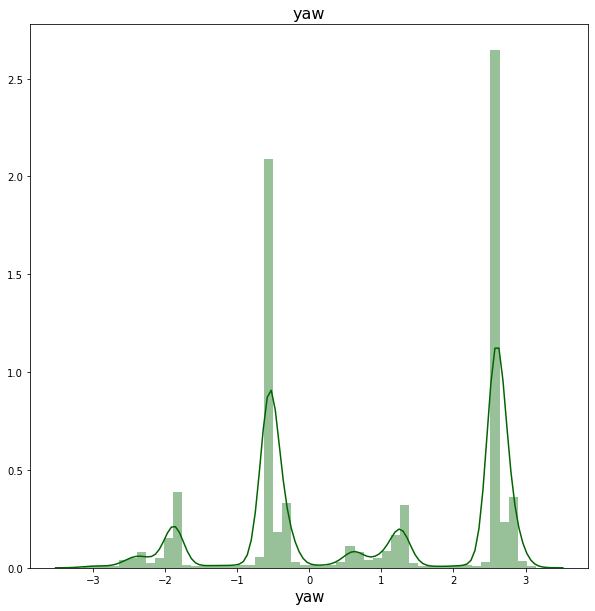

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['yaw'], color='darkgreen', ax=ax).set_title('yaw', fontsize=16)
plt.xlabel('yaw', fontsize=15)
plt.show()

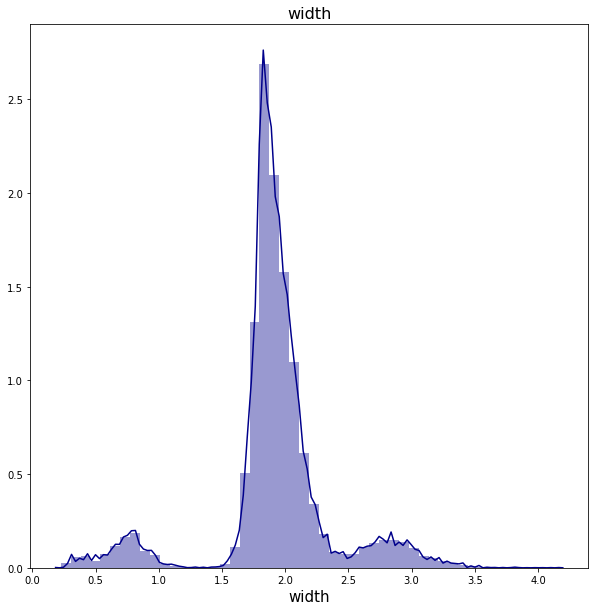

In [95]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['width'], color='darkblue', ax=ax).set_title('width', fontsize=16)
plt.xlabel('width', fontsize=15)
plt.show()

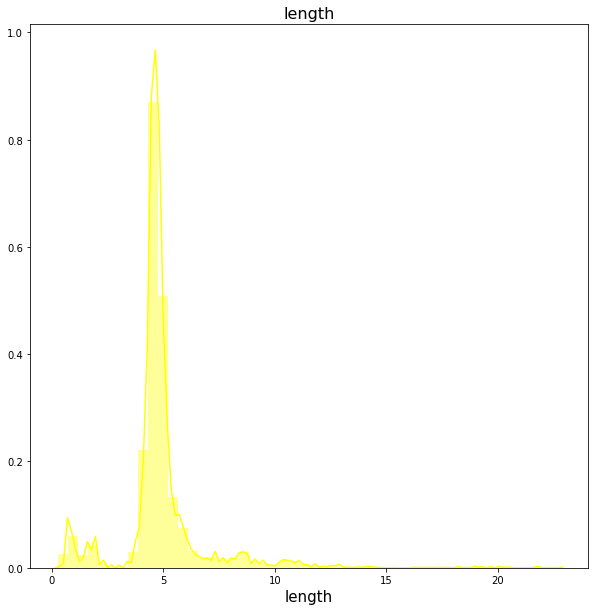

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['length'], color='yellow', ax=ax).set_title('length', fontsize=16)
plt.xlabel('length', fontsize=15)
plt.show()

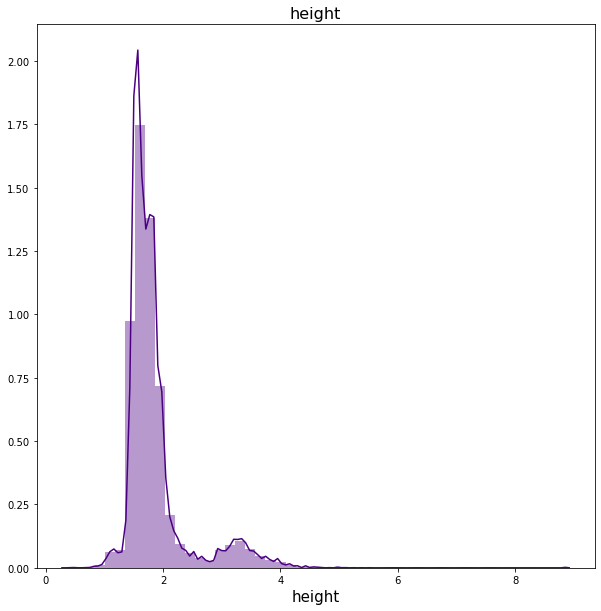

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(train_objects['height'], color='indigo', ax=ax).set_title('height', fontsize=16)
plt.xlabel('height', fontsize=15)
plt.show()

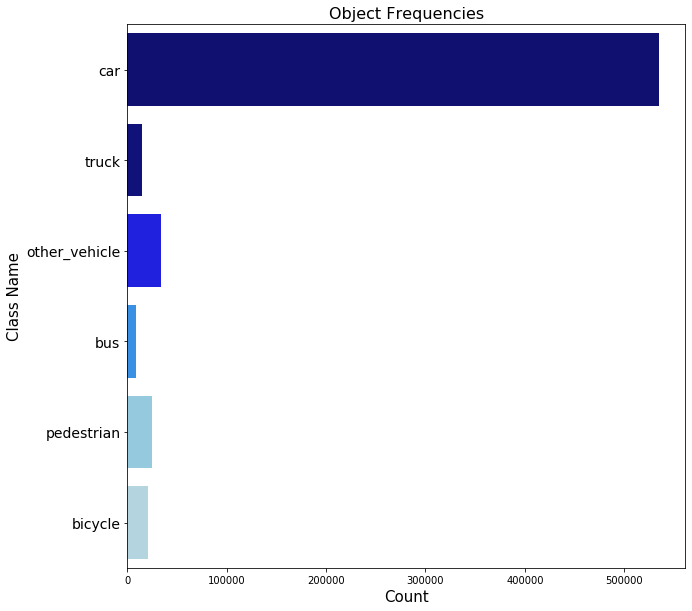

In [99]:
fig, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(y="class_name", data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                     palette=['navy', 'darkblue', 'blue', 'dodgerblue', 'skyblue', 'lightblue']).set_title('Object Frequencies', fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Count", fontsize=15)
plt.ylabel("Class Name", fontsize=15)
plt.show(plot)

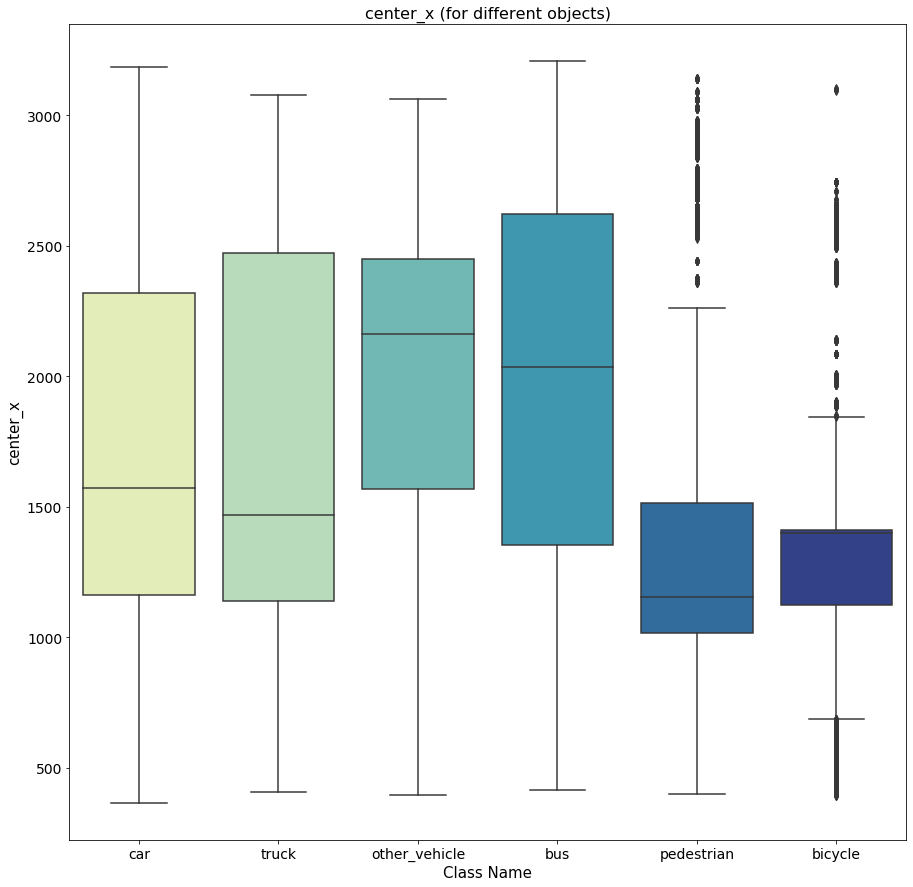

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="center_x",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGnBu', ax=ax).set_title('center_x (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_x", fontsize=15)
plt.show(plot)

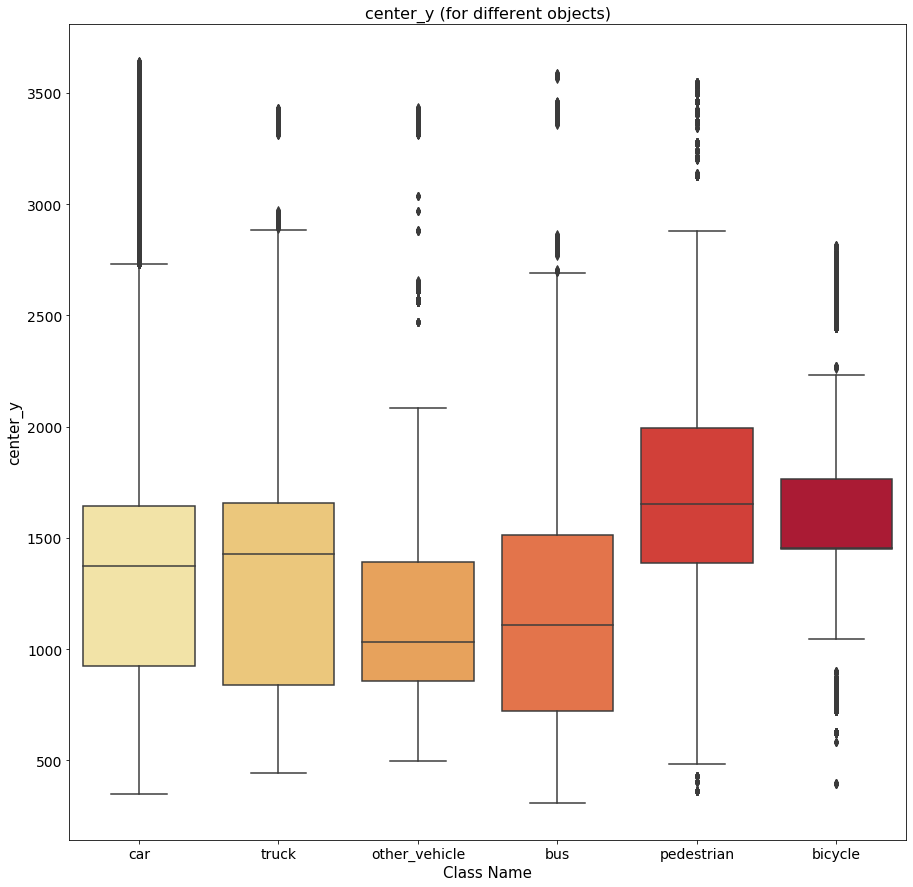

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="center_y",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlOrRd', ax=ax).set_title('center_y (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_y", fontsize=15)
plt.show(plot)

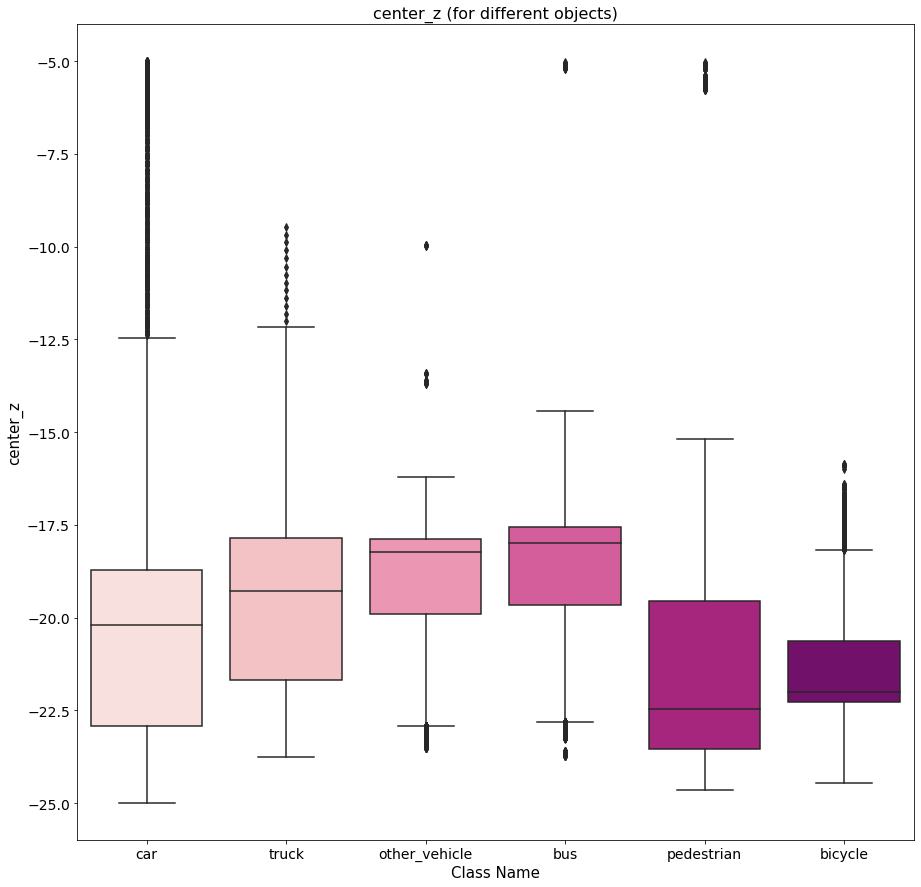

In [21]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="center_z",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"').query('center_z <= -5'),
                   palette='RdPu', ax=ax).set_title('center_z (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("center_z", fontsize=15)
plt.show(plot)

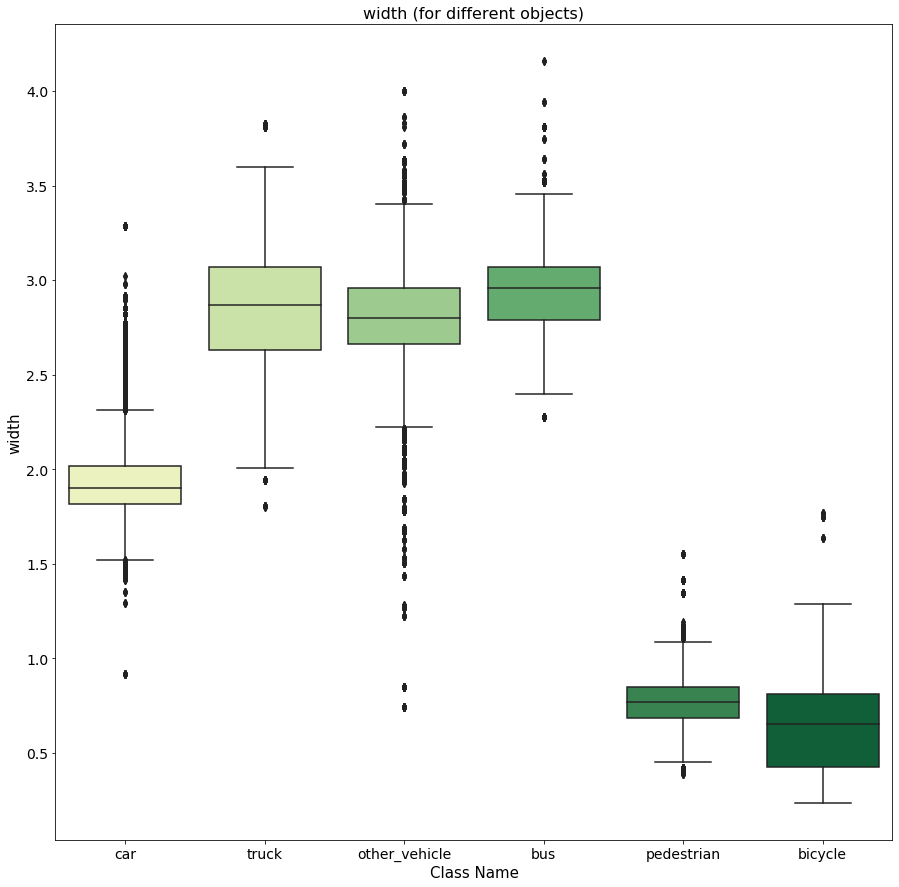

In [22]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="width",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal"'),
                   palette='YlGn', ax=ax).set_title('width (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("width", fontsize=15)
plt.show(plot)

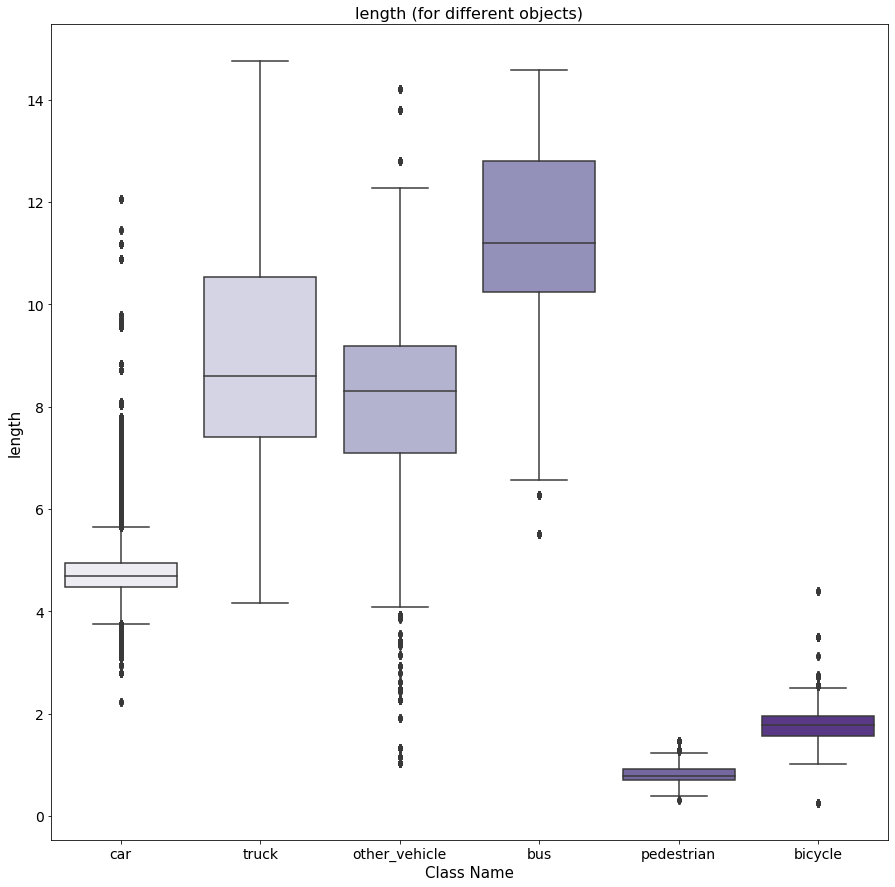

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="length",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal" and length < 15'),
                   palette='Purples', ax=ax).set_title('length (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("length", fontsize=15)
plt.show(plot)

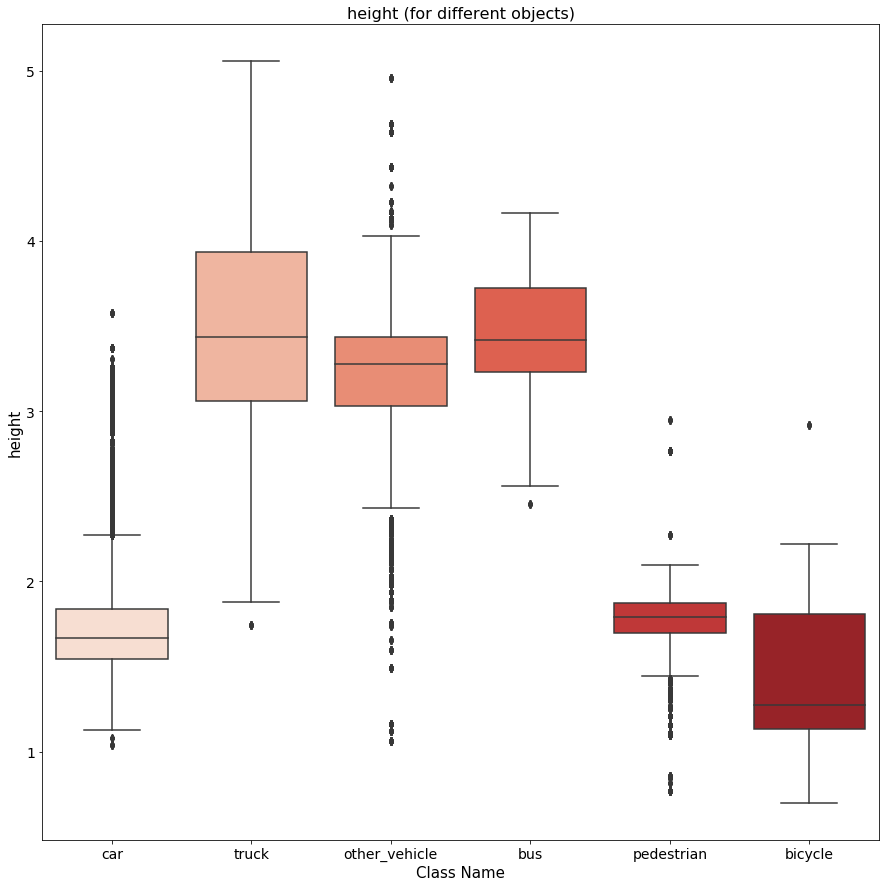

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

plot = sns.boxplot(x="class_name", y="height",
                   data=train_objects.query('class_name != "motorcycle" and class_name != "emergency_vehicle" and class_name != "animal" and height < 6'),
                   palette='Reds', ax=ax).set_title('height (for different objects)', fontsize=16)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Class Name", fontsize=15)
plt.ylabel("height", fontsize=15)
plt.show(plot)

In [25]:
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_images images
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_maps maps
!ln -s /kaggle/input/3d-object-detection-for-autonomous-vehicles/train_lidar lidar

In [27]:
lyft_data = LyftDataset(
    data_path='.',
    json_path='train_data', 
    verbose=True
)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 19.0 seconds.
Reverse indexing ...
Done reverse indexing in 4.6 seconds.


In [28]:
train = pd.read_csv('train.csv')
sub = pd.read_csv('sample_submission.csv')
print(train.shape)
train.head()

(22680, 2)


Id  \
0  db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...   
1  edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...   
2  1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...   
3  a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...   
4  b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...   

                                    PredictionString  
0  2680.2830359778527 698.1969292852777 -18.04776...  
1  1208.642684768659 1585.1812946970927 -23.56236...  
2  848.9346793681768 2587.2870557176507 -20.15995...  
3  1994.4320280494098 1128.30164336183 -18.054752...  
4  1030.3877156973385 1667.13131694941 -23.764820...

In [34]:
os.listdir('train_images')[:10]

['host-a101_cam1_1243102882865357006.jpeg',
 'host-a011_cam2_1233688942517605006.jpeg',
 'host-a004_cam6_1233014852050948006.jpeg',
 'host-a101_cam0_1240877588450000006.jpeg',
 'host-a011_cam5_1235933629367719006.jpeg',
 'host-a004_cam3_1233014845200897006.jpeg',
 'host-a007_cam4_1233508031384150006.jpeg',
 'host-a007_cam0_1234740244450897006.jpeg',
 'host-a011_cam5_1232839954867719006.jpeg',
 'host-a102_cam0_1241468930450000006.jpeg']

In [35]:
os.listdir('train_data')

['ego_pose.json',
 'sample_annotation.json',
 'scene.json',
 'log.json',
 'sample_data.json',
 'instance.json',
 'visibility.json',
 'category.json',
 'sensor.json',
 'sample.json',
 'attribute.json',
 'map.json',
 'calibrated_sensor.json']

In [38]:
with open('train_data/sample_data.json') as f:
    data_json = json.load(f)

print("There are", len(data_json), "records in sample_data.json")

print("\nBelow is a record containing lidar data:")
print(data_json[0])

print('\n This one contains information about image data:')
print(data_json[2])

There are 189504 records in sample_data.json

Below is a record containing lidar data:
{'is_key_frame': True, 'prev': 'd190078ec7869ad5c9e5417371aa3b45eb1c22804a0a290ed4695042799b7470', 'fileformat': 'bin', 'token': 'ad87e1763749cc8562cca68e2046db128185c80c3e759919f5da448e5d9d9696', 'timestamp': 1549920983701948.2, 'next': '8182fb6868baf63c245a4994b7f3034a7d281d1928a7844b7b7159cff3b91a1e', 'ego_pose_token': 'd90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeaebdcefbf4529209237f', 'sample_token': 'fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced363a2ebac41f465830d', 'filename': 'lidar/host-a007_lidar1_1233956183701948366.bin', 'calibrated_sensor_token': '3b463530b5bae9698c9cc803c1731c36abd359a7296e23e81f8c0b546f60e749'}

 This one contains information about image data:
{'width': 2048, 'height': 864, 'calibrated_sensor_token': '30fcfa36375c0d36fce508cd04c9b1dd07ac283eb873528196f640bba983890e', 'token': '454c65ee6c297d64b17852b4c56def9781a84dcb8558a8f448ac29a259db9afd', 'sample_token': '254cea140f

In [40]:
with open('train_data/scene.json') as f:
    scene_json = json.load(f)

print("There are", len(scene_json), "records in sample_data.json")
print(scene_json[0])

There are 180 records in sample_data.json
{'log_token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100', 'first_sample_token': '24b0962e44420e6322de3f25d9e4e5cc3c7a348ec00bfa69db21517e4ca92cc8', 'name': 'host-a101-lidar0-1241893239199111666-1241893264098084346', 'description': '', 'last_sample_token': '2346756c83f6ae8c4d1adec62b4d0d31b62116d2e1819e96e9512667d15e7cec', 'nbr_samples': 126, 'token': 'da4ed9e02f64c544f4f1f10c6738216dcb0e6b0d50952e158e5589854af9f100'}


In [41]:
lidar_data = []
image_data = []

for record in data_json:
    if record['fileformat'] == 'jpeg':
        image_data.append(record)
    else:
        lidar_data.append(record)

In [42]:
lidar_df = pd.DataFrame(lidar_data)
image_df = pd.DataFrame(image_data)

print(lidar_df.shape)
print(image_df.shape)

(30744, 10)
(158760, 12)


In [43]:
lidar_df.head()

is_key_frame                                               prev fileformat  \
0          True  d190078ec7869ad5c9e5417371aa3b45eb1c22804a0a29...        bin   
1          True  83f6f61cb6f2fc9b985cc23bd5613219eee7da390cd083...        bin   
2          True  89e066a61d09acfb201c91d9f2b9bef2d89d96a22ab41e...        bin   
3          True  1ffe5657fd754b92d05d57f9ec3f37c9b069e833a259c9...        bin   
4          True  01c72cbe2a64b4bfff53eab1ff38551789d01092e8bd79...        bin   

                                               token     timestamp  \
0  ad87e1763749cc8562cca68e2046db128185c80c3e7599...  1.549921e+15   
1  ea079138d89f3887b2bfcddfe16b747e2ec7a366ce66b3...  1.551742e+15   
2  5146c66963a2100cc5850485741dbf30aae6fc500a684b...  1.551389e+15   
3  7177b0b2e73ea0a6d73839247e72d4e35bd549eeab7e78...  1.557852e+15   
4  b5dacfbb238e360b50906c21a73c7dca8537519ddf94bf...  1.549929e+15   

                                                next  \
0  8182fb6868baf63c245a4994b7f3034a7d281d1928a784...   
1  c291c5e9c1c70363496e304e964a33036cace6d14c177e...   
2  3f2ef26d47f69a1f0ad69393d065fd8d29fcdcb5a0cf03...   
3  d431edff8cebbb565f9123d09c730cd52ad7813209e37f...   
4  0b90fdc978baf242d885ad47185c593e34628ce43533f2...   

                                      ego_pose_token  \
0  d90d278f2084ae64c98b0aa2dd8d4f83c023f1313beeae...   
1  97c348ec54ca0cfc892361595513d34d19e53583f97832...   
2  c51a6d17e3c5c17d0a4a8a0208785143b060d954dd78bb...   
3  d4d46e75513a9418e5ea8bbec51676466b92721621a453...   
4  2b5a7e74340e46e3ae3a308720c6c00b101b9c3116dcfd...   

                                        sample_token  \
0  fd5f1c634b59e3b4e0f7a5c48c768a7d334a63221fced3...   
1  c60dc70e93949cbefdda68813cf024fe8e9103bc8a68d6...   
2  2bd45a80fba943914188bc31fa3bc8a5b9b4156da4376c...   
3  3e6998e0d88bb40d202fe36dead331ede18b94d0181476...   
4  0bb8cbe863448bcf20d4bb4afd52943755ee277448f764...   

                                         filename  \
0  lidar/host-a007_lidar1_1233956183701948366.bin   
1  lidar/host-a008_lidar1_1235777221601281486.bin   
2  lidar/host-a015_lidar1_1235423703101689806.bin   
3  lidar/host-a101_lidar0_1241887000402380046.bin   
4  lidar/host-a011_lidar1_1233964287001654806.bin   

                             calibrated_sensor_token  
0  3b463530b5bae9698c9cc803c1731c36abd359a7296e23...  
1  2dba2d3171d7c60b847d65d96babfd7efb487428fa5a3c...  
2  7efae113b75a3c387bb2a92439be7e795e5caabd5819b4...  
3  7575ccf88b92f9aab15b49679e86f1b03cf8050cf9b2b3...  
4  043947e092f2df7723186143caafad12b5f4ae51328ce0...

In [44]:
image_df.head()

width  height                            calibrated_sensor_token  \
0   2048     864  30fcfa36375c0d36fce508cd04c9b1dd07ac283eb87352...   
1   1224    1024  76e7bb72dd96cb18f5c75abae3b5bab5e41bd4aac39445...   
2   1224    1024  aac6241dd5e28264de261422696af2037868c5133d9329...   
3   1920    1080  c63ee9e8447236363329b16551200c1216313f3e110797...   
4   1224    1024  4a1b6804918907b7944679c90319c9d595966a7b17fb2f...   

                                               token  \
0  454c65ee6c297d64b17852b4c56def9781a84dcb8558a8...   
1  779018e1f92debcf5c5c28e9577677c6595679780bdf9b...   
2  d966960819eb0aca2883cd3c8d8c5e2540bda952a8cada...   
3  c38472dca62728a33c15da9de3bc21aa57a063881aafaa...   
4  0cdaef801e20d2d917dd35719c224447c6eff899dfda55...   

                                        sample_token  is_key_frame  \
0  254cea140f7d14fc86e73f789794fb73f81c05831d40f3...          True   
1  810503d8ca51e9692021ecb56e2b2f2098beaf396cd207...          True   
2  119b8c4bbaf1493bebaaa7d823934a8a3f5a80fb095630...          True   
3  32a71cf987e8922a85d052bfcc477e19c56733f453bc94...          True   
4  d1b36f15c13de84d38a795dbbc2fe42a848f5f83968d42...          True   

                                                prev fileformat  \
0  44555daed204fea486ec10ea1747432501b9f06fe93041...       jpeg   
1  de75f3f347742035f2442f4a5fa0334946642daa2d07d8...       jpeg   
2  a208568472ef6719faa2540622ada30b004583de9153f4...       jpeg   
3  220414fac0cfd44a49e117130bef1ca0e9dddc39e72554...       jpeg   
4  14477cc6bc8f5b2cdbba889b52db4f67e6a1f59da90e21...       jpeg   

                                      ego_pose_token     timestamp  \
0  dce9c81e168db4f6fa442cc0bd484a4926dfe73946ba59...  1.550705e+15   
1  bb93bbeb3b6d151c805729dba52d4c0c0070f20376090b...  1.546901e+15   
2  53f6821330f6bc07603db70fde1a96b25bd919471e923c...  1.549650e+15   
3  ce6c85258e5106a53de9a3700ecc59f23d9c7ccdc466b7...  1.558714e+15   
4  bf118e2bbd867e4ddb513fc91285d509a68bf201b8eb52...  1.549055e+15   

                                                next  \
0  d4b751751ca5424375d0faf3d22b9af83e7c84e1598ba0...   
1  4796998aae092f295fe4f96ce57fc673e3292c7b0368ac...   
2  1a82a24dafde93234579ae59f48498a8436361cc641a64...   
3  4f01dd3050dacfcce8f0509c1b9da6918c262efcd7672c...   
4  b5c54854f43d106b980f9074dc9f8209a0c29a2d31af51...   

                                         filename  
0  images/host-a007_cam6_1234740264650905006.jpeg  
1  images/host-a007_cam3_1230936242299360006.jpeg  
2  images/host-a004_cam2_1233685223917652006.jpeg  
3  images/host-a101_cam5_1242748828932442006.jpeg  
4  images/host-a011_cam5_1233090640267719006.jpeg

In [45]:
image_df['host'] = image_df['filename'].apply(lambda st: st.strip('images/host-').split('_')[0])
image_df['cam'] = image_df['filename'].apply(lambda st: st.split('_')[1])
image_df['timestamp'] = image_df['filename'].apply(lambda st: st.split('_')[2].strip('.jpeg'))

In [46]:
image_df.head()

width  height                            calibrated_sensor_token  \
0   2048     864  30fcfa36375c0d36fce508cd04c9b1dd07ac283eb87352...   
1   1224    1024  76e7bb72dd96cb18f5c75abae3b5bab5e41bd4aac39445...   
2   1224    1024  aac6241dd5e28264de261422696af2037868c5133d9329...   
3   1920    1080  c63ee9e8447236363329b16551200c1216313f3e110797...   
4   1224    1024  4a1b6804918907b7944679c90319c9d595966a7b17fb2f...   

                                               token  \
0  454c65ee6c297d64b17852b4c56def9781a84dcb8558a8...   
1  779018e1f92debcf5c5c28e9577677c6595679780bdf9b...   
2  d966960819eb0aca2883cd3c8d8c5e2540bda952a8cada...   
3  c38472dca62728a33c15da9de3bc21aa57a063881aafaa...   
4  0cdaef801e20d2d917dd35719c224447c6eff899dfda55...   

                                        sample_token  is_key_frame  \
0  254cea140f7d14fc86e73f789794fb73f81c05831d40f3...          True   
1  810503d8ca51e9692021ecb56e2b2f2098beaf396cd207...          True   
2  119b8c4bbaf1493bebaaa7d823934a8a3f5a80fb095630...          True   
3  32a71cf987e8922a85d052bfcc477e19c56733f453bc94...          True   
4  d1b36f15c13de84d38a795dbbc2fe42a848f5f83968d42...          True   

                                                prev fileformat  \
0  44555daed204fea486ec10ea1747432501b9f06fe93041...       jpeg   
1  de75f3f347742035f2442f4a5fa0334946642daa2d07d8...       jpeg   
2  a208568472ef6719faa2540622ada30b004583de9153f4...       jpeg   
3  220414fac0cfd44a49e117130bef1ca0e9dddc39e72554...       jpeg   
4  14477cc6bc8f5b2cdbba889b52db4f67e6a1f59da90e21...       jpeg   

                                      ego_pose_token            timestamp  \
0  dce9c81e168db4f6fa442cc0bd484a4926dfe73946ba59...  1234740264650905006   
1  bb93bbeb3b6d151c805729dba52d4c0c0070f20376090b...  1230936242299360006   
2  53f6821330f6bc07603db70fde1a96b25bd919471e923c...  1233685223917652006   
3  ce6c85258e5106a53de9a3700ecc59f23d9c7ccdc466b7...  1242748828932442006   
4  bf118e2bbd867e4ddb513fc91285d509a68bf201b8eb52...  1233090640267719006   

                                                next  \
0  d4b751751ca5424375d0faf3d22b9af83e7c84e1598ba0...   
1  4796998aae092f295fe4f96ce57fc673e3292c7b0368ac...   
2  1a82a24dafde93234579ae59f48498a8436361cc641a64...   
3  4f01dd3050dacfcce8f0509c1b9da6918c262efcd7672c...   
4  b5c54854f43d106b980f9074dc9f8209a0c29a2d31af51...   

                                         filename host   cam  
0  images/host-a007_cam6_1234740264650905006.jpeg  007  cam6  
1  images/host-a007_cam3_1230936242299360006.jpeg  007  cam3  
2  images/host-a004_cam2_1233685223917652006.jpeg  004  cam2  
3  images/host-a101_cam5_1242748828932442006.jpeg  101  cam5  
4  images/host-a011_cam5_1233090640267719006.jpeg  011  cam5

In [47]:
image_df.to_csv("sample_data_images.csv")
lidar_df.to_csv("lidar_data_images.csv")

In [48]:
image_df['host'].value_counts()

011    44982
004    37044
007    22932
101    17640
102    10584
009     7938
015     5292
008     4410
006     2646
017     2646
012     1764
005      882
Name: host, dtype: int64

In [49]:
image_df['cam'].value_counts()

cam3    22680
cam1    22680
cam5    22680
cam4    22680
cam0    22680
cam6    22680
cam2    22680
Name: cam, dtype: int64

In [54]:
def display_host_sample(host, n_images, jumps=1):
    cams = list(sorted(image_df['cam'].unique()))
    
    fig, axs = plt.subplots(
        n_images, len(cams), figsize=(3*len(cams), 3*n_images), 
        sharex=True, sharey=True, gridspec_kw = {'wspace':0.1, 'hspace':0.1}
    )
    
    for i in range(n_images):
        for c, cam in enumerate(cams):
            if i == 0:
                axs[i, c].set_title(cam)
            
            mask1 = image_df.cam == cam
            mask2 = image_df.host == host
            image_path = image_df[mask1 & mask2]
            image_path = image_path.sort_values('timestamp')['filename'].iloc[i*jumps]
            
            img = cv2.imread('train_' + image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (200, 200))
            
            axs[i, c].imshow(img)
            axs[i, c].axis('off')

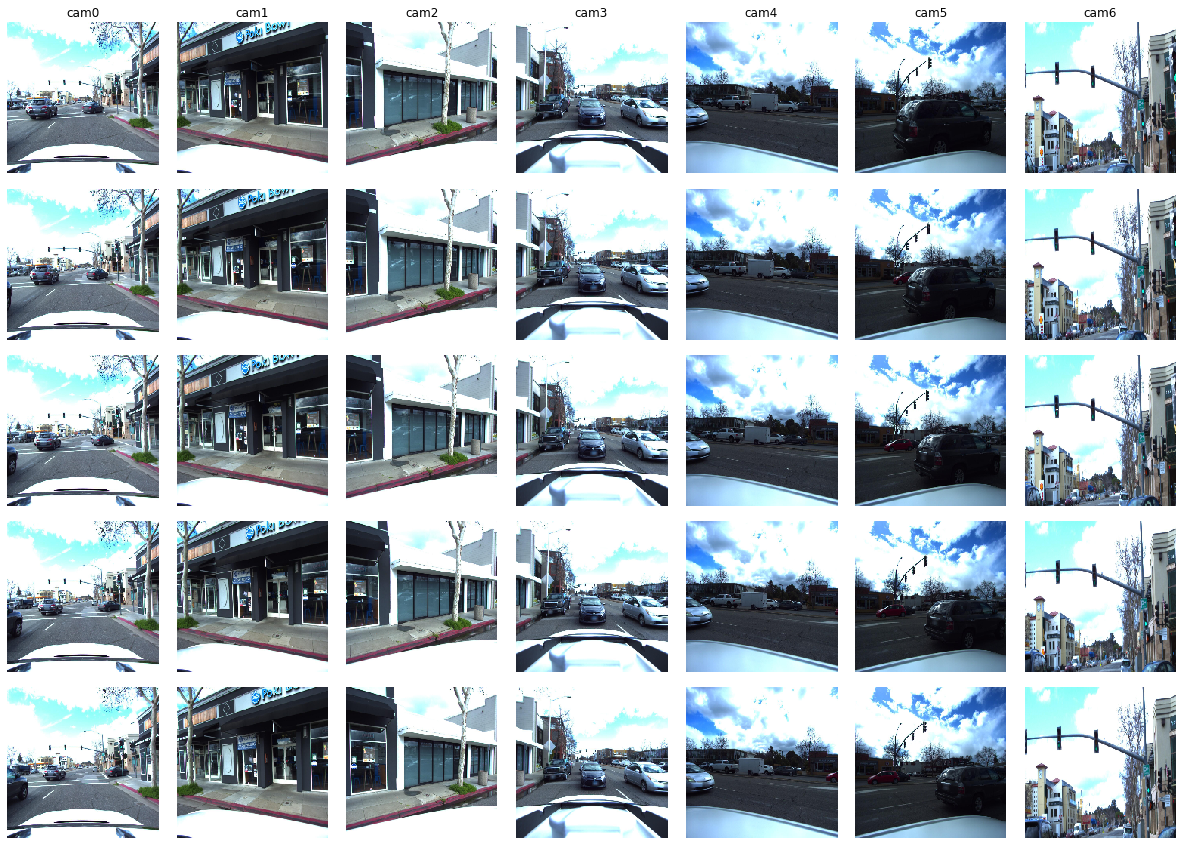

In [55]:
display_host_sample('017', 5, jumps=1)

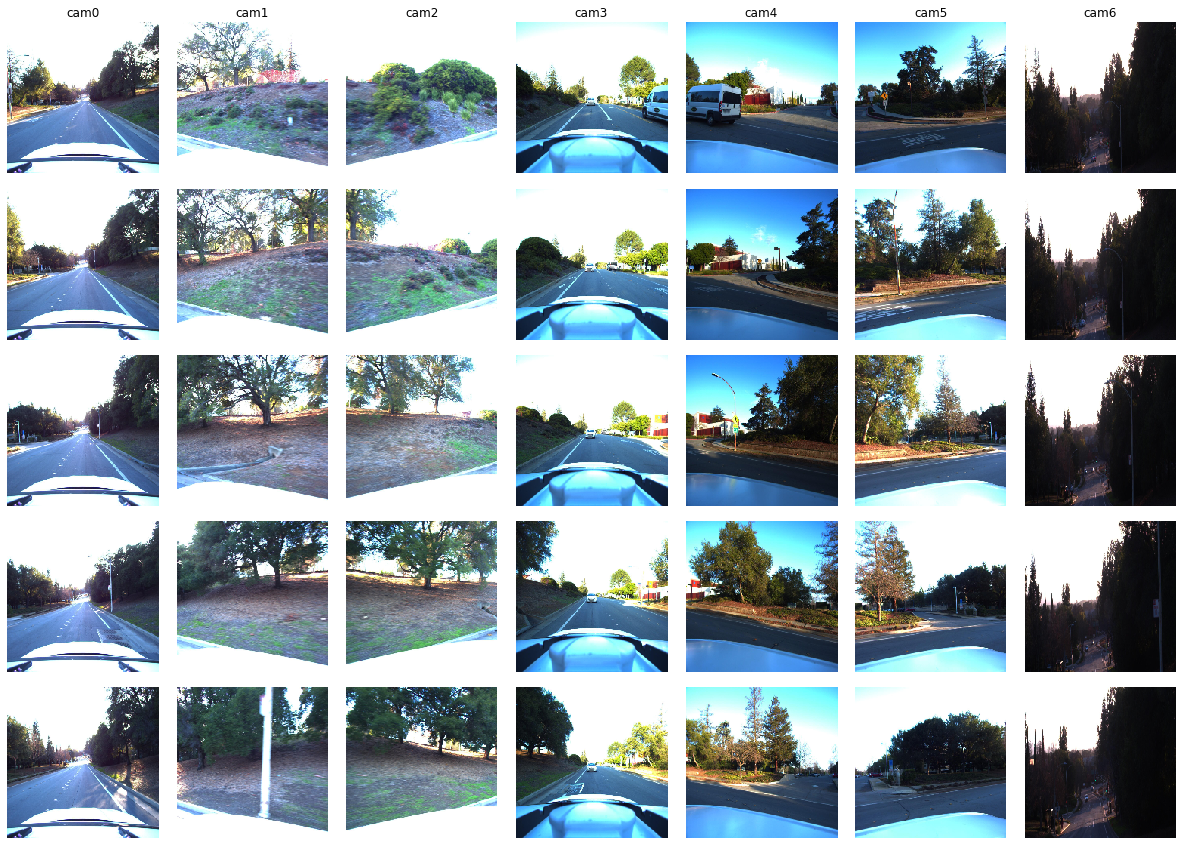

In [56]:
display_host_sample('009', 5, jumps=5)

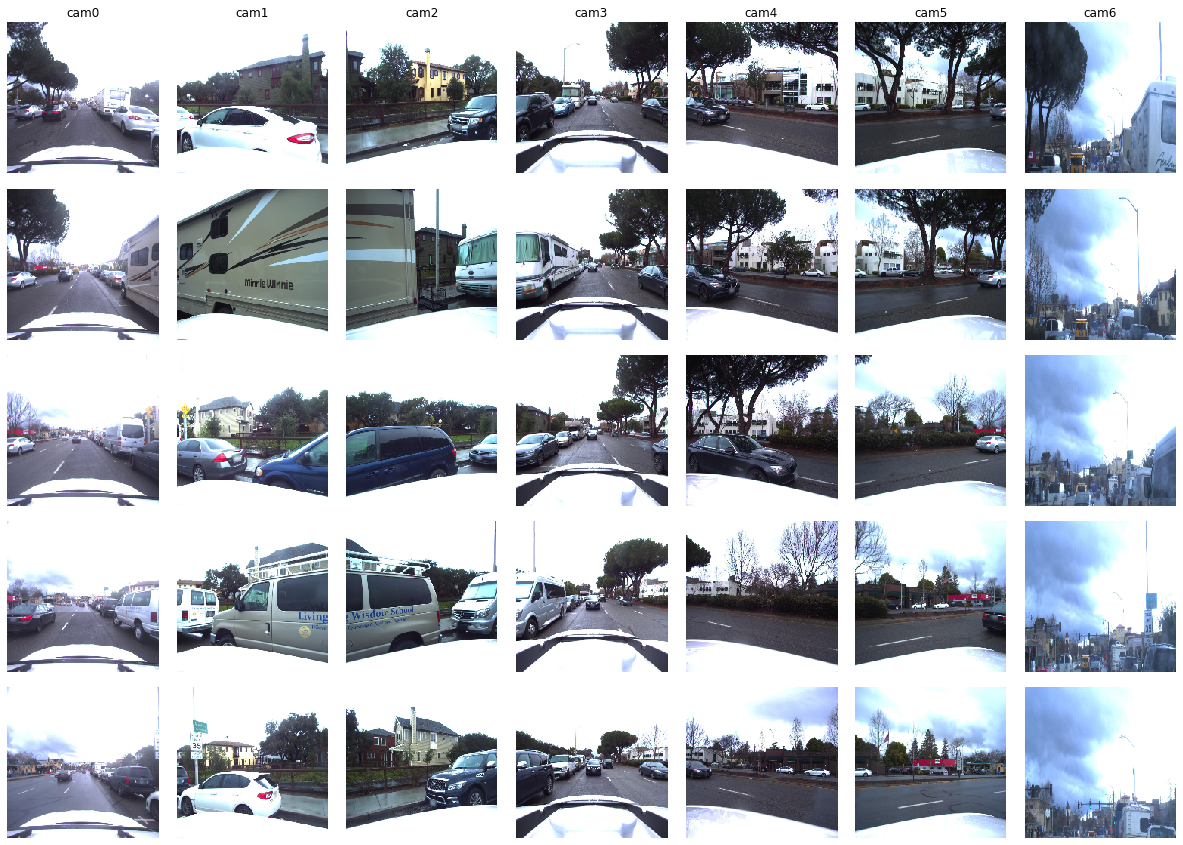

In [57]:
display_host_sample('012', 5, jumps=10)